In [1]:
from sklearn.datasets import load_iris
import numpy as np

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Select only two features (first two)
X_selected = X[:, :2]

# Select only two classes (0 and 1) and their corresponding features
selected_indices = np.where((y == 0) | (y == 1))
X_filtered = X_selected[selected_indices]
y_filtered = y[selected_indices]

# Convert to numpy arrays (already done by slicing numpy arrays, but good to be explicit)
X_filtered_np = np.array(X_filtered)
y_filtered_np = np.array(y_filtered)

print("Shape of selected and filtered features:", X_filtered_np.shape)
print("Shape of selected and filtered labels:", y_filtered_np.shape)
print("First 5 rows of selected and filtered features:\n", X_filtered_np[:5])
print("First 5 rows of selected and filtered labels:\n", y_filtered_np[:5])

Shape of selected and filtered features: (100, 2)
Shape of selected and filtered labels: (100,)
First 5 rows of selected and filtered features:
 [[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]]
First 5 rows of selected and filtered labels:
 [0 0 0 0 0]


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


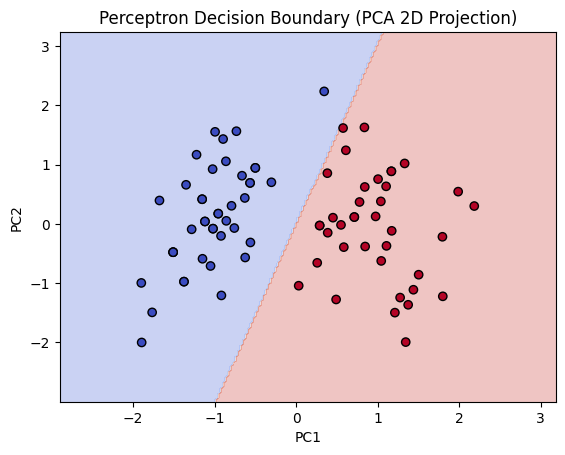

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # --------------------
# # 1. Load the dataset
# # --------------------
# data = pd.read_csv("diabetes.csv")

# # Columns that cannot realistically be zero
# zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
# for col in zero_cols:
#     data[col] = data[col].replace(0, np.nan)
#     data[col] = data[col].fillna(data[col].median())  # median imputation

# --------------------
# 2. Prepare data
# --------------------
# X = data.drop("Outcome", axis=1).values
# y = data["Outcome"].values

X = X_filtered_np
y = y_filtered_np

# Feature scaling
#y = data["Outcome"].values

# Feature scaling (manual standardization)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Manual train-test split (80/20)
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, test_idx = indices[:split], indices[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# --------------------
# 3. Perceptron Implementation
# --------------------
class Perceptron:
    def __init__(self, learning_rate=0.01, n_epochs=100):
        self.lr = learning_rate
        self.n_epochs = n_epochs

    def activation(self, z):
        return np.where(z >= 0, 1, 0)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_epochs):
            for xi, target in zip(X, y):
                z = np.dot(xi, self.weights) + self.bias
                y_pred = self.activation(z)
                update = self.lr * (target - y_pred)
                self.weights += update * xi
                self.bias += update

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.activation(z)

# --------------------
# 4. Train the model
# --------------------
perceptron = Perceptron(learning_rate=0.01, n_epochs=50)
perceptron.fit(X_train, y_train)

# --------------------
# 5. Evaluation
# --------------------
y_pred = perceptron.predict(X_test)

accuracy = np.mean(y_pred == y_test)
tp = np.sum((y_test == 1) & (y_pred == 1))
tn = np.sum((y_test == 0) & (y_pred == 0))
fp = np.sum((y_test == 0) & (y_pred == 1))
fn = np.sum((y_test == 1) & (y_pred == 0))

precision = tp / (tp + fp + 1e-10)
recall = tp / (tp + fn + 1e-10)
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# --------------------
# 6. PCA from scratch for visualization
# --------------------
# Covariance matrix
cov_matrix = np.cov(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Sort by largest eigenvalues
sorted_indices = np.argsort(eig_vals)[::-1]
eig_vecs = eig_vecs[:, sorted_indices[:2]]

# Project to 2D
X_train_pca = X_train.dot(eig_vecs)

# --------------------
# 7. Plot decision boundary
# --------------------
# Create grid
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Project grid back to original feature space
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_orig_space = grid_points.dot(eig_vecs.T)

# Predict using trained perceptron
Z = perceptron.predict(grid_orig_space)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.title("Perceptron Decision Boundary (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
